In [5]:
import sys

sys.path.append('../../')

import numpy as np
import pylab as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

import lightning as L

from sklearn import datasets

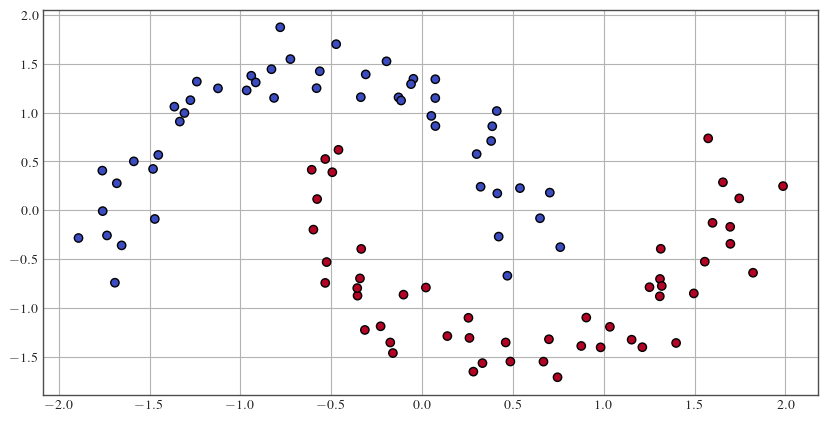

In [6]:
X, y = datasets.make_moons(100, noise=.1, random_state=42)
# X, y = datasets.make_circles(500, noise=.02)
X = (X - X.mean(0)) / X.std(0)
X = torch.from_numpy(X).float()
y = torch.from_numpy(y).long()

train_ds = torch.utils.data.TensorDataset(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()

In [7]:
from dal_toolbox.models.deterministic.base import DeterministicModule
from dal_toolbox.models.utils.callbacks import MetricsHistory

class Model(DeterministicModule):
    def __init__(self,
                 num_classes: int = 2,
                 dropout_rate: int = .2,
                 feature_dim: int = 128,
                 ):
        super().__init__()

        self.first = nn.Linear(2, feature_dim)
        self.first_dropout = nn.Dropout(dropout_rate)
        self.hidden = nn.Linear(feature_dim, feature_dim)
        self.hidden_dropout = nn.Dropout(dropout_rate)
        self.last = nn.Linear(feature_dim, num_classes)
        self.act = nn.ReLU()

    def forward(self, x, return_feature=False):
        x = self.act(self.first(x))
        x = self.first_dropout(x)
        x = self.act(self.hidden(x))
        x = self.hidden_dropout(x)
        out = self.last(x)
        if return_feature:
            return out, x
        return out

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr=1e-1, momentum=0.9, weight_decay=1e-3)
        return optimizer

In [8]:
@torch.no_grad()
def plot_contour(model, domain=5, ax=None):
    model.eval()
    model.cpu()
    if ax:
        plt.sca(ax)
    xx, yy = torch.meshgrid(torch.linspace(-domain, domain, 51), torch.linspace(-domain, domain, 51))
    zz = torch.stack((xx.flatten(), yy.flatten()), dim=1)

    logits = model(zz)
    probas = logits.softmax(-1)
    zz = probas[:, 1].view(xx.shape)

    plt.contourf(xx, yy, zz, alpha=.8, zorder=-1, levels=np.linspace(0, 1, 6))
    plt.colorbar()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type    | Params
-------------------------------------------
0 | first          | Linear  | 384   
1 | first_dropout  | Dropout | 0     
2 | hidden         | Linear  | 16.5 K
3 | hidden_dropout | Dropout | 0     
4 | last           | Linear  | 258   
5 | act            | ReLU    | 0     
-------------------------------------------
17.2 K    Trainable params
0         Non-trainable params
17.2 K    Total params
0.069     Total estimated model params size (MB)
/home/denis/miniconda3/envs/dal-toolbox/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the nu

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 169.77it/s, v_num=84, loss=0.0135] 

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 108.05it/s, v_num=84, loss=0.0135]


/home/denis/miniconda3/envs/dal-toolbox/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


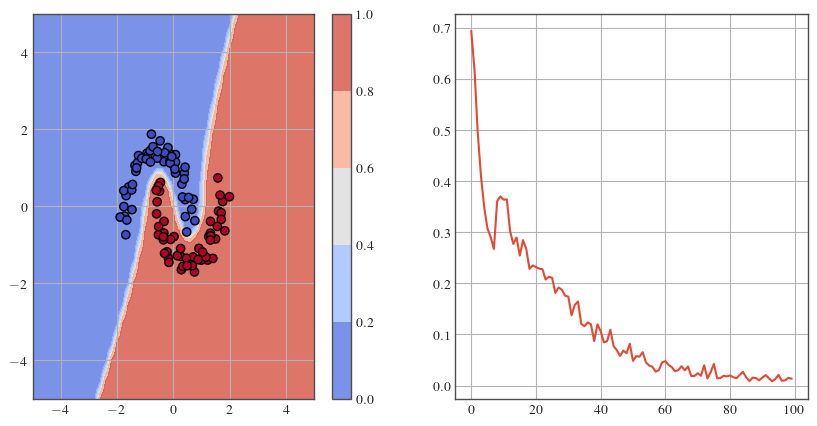

In [9]:
num_epochs = 100
torch.manual_seed(0)
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=128, shuffle=True)


model = Model()
history = MetricsHistory()
trainer = L.Trainer(max_epochs=num_epochs, callbacks=[history])
trainer.fit(model, train_loader)

model.eval()
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.scatter(X[:, 0], X[:, 1], c=y)
plot_contour(model)
plt.subplot(122)
plt.plot([h['loss'] for h in history])
plt.show()